In [1]:
from matplotlib.pyplot import *
import numpy as np
import h5py
from Data_Core.experiment import *
from Data_Core.digital_twin import *
from tqdm import tqdm
#from src.algorithms import *
#import torch
import sklearn
%load_ext autoreload
import scipy

In [2]:
def find_index(wavelenghts,w):
    return np.argmin(np.abs(wavelenghts - w))


In [3]:
def Raman_data_loader(filename):

    with h5py.File(filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [4]:
filename = "2023913_1110.h5"
#filename = "2023811_1451.h5"
spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(filename)

In [5]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter = 10):
    L = len(y)
    D = sparse.diags([1, -2, 1],[0, -1, -2], shape = (L, L - 2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z

In [6]:
lam = 1e2
p = 1e-1
    
pro_data = 1*spectrum_raman
for i in tqdm(range(0, pro_data.shape[0])):
    for j in range(0, pro_data.shape[1]):
        # print(i,j,end='\r')
        spec = 1 * pro_data[i, j, :]
        pro_data[i, j, :] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [08:09<00:00,  1.96s/it]


In [7]:
pro_data_norm=pro_data.copy()
for i in range(0,pro_data.shape[0]):
    for j in range(0,pro_data.shape[1]):
        spec = 1 * pro_data[i,j, :]
        sum_spec=np.sum(spec)
        pro_data_norm[i,j,:]=spec/sum_spec

In [8]:
offset_l = 31
offset_m = 328

mask = pro_data_norm[:, :, offset_l:offset_m].reshape(pro_data.shape[0]*pro_data.shape[1], -1)


In [9]:
threshold = 1.27e-9

mask_offset = np.array(mask)
mask_t = np.array([(mask_offset[:, i])*((mask_offset[:, i] > threshold)) for i in range(mask_offset.shape[-1])])

In [10]:
mask_min_max = np.array([(mask_t[i, :] - mask_t[:, :].min()+ 1e-5)/(mask_t[:, :].max() - mask_t[:, :].min() + 1e-5) for i in range(mask_t.shape[0])])

In [11]:
def read_ref(mineral):
    df = pd.read_csv(mineral + '_raman.txt',header=13,names=['wavenumber','int'],skipfooter=4,engine='python' )
    return np.array(df['wavenumber']),np.array(df['int'])

In [12]:
entropy_masks=mask_min_max*255

## Entropia

In [13]:
def entropy_calc(map_gr,lim=255):
    import cv2
    from scipy.stats import entropy

    #image

    _bins = 200

    hist, _ = np.histogram(map_gr, bins=_bins, range=(0, lim))

    prob_dist = hist / hist.sum()
    image_entropy = entropy(prob_dist, base=2)
    return image_entropy

In [14]:
offset_l = 31
offset_m = 328
wavelengths_raman.shape
wavelengths=wavelengths_raman[offset_l:offset_m]

minerals = {
    
    'Albite':[508.1],
    'Background':[733.1],
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5]}

mineral_list = list(minerals.keys())

find_index = lambda wavelenghts,w : np.argmin(np.abs(wavelengths-w))

significant_w=[]
for i,mineral in enumerate(mineral_list):
    wn=find_index(wavelengths,minerals[mineral][0])
    significant_w.append(wn)

In [15]:
image_entropy=[]
for i in range(297):
    map_gr=entropy_masks[i]
    image_entropy.append(entropy_calc(map_gr))

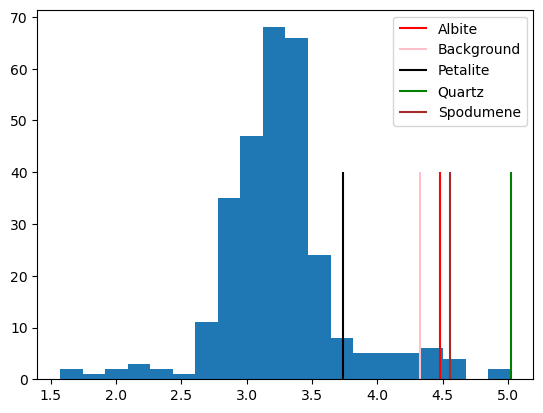

In [16]:
plt.hist(image_entropy,bins=20)
colors=['red','pink','black','green','brown']
for i in range(len(significant_w)):
    plt.vlines(image_entropy[significant_w[i]],0,40,color=colors[i],label=mineral_list[i])
    
plt.legend()

In [17]:
## mantendo so as energias maximas
relevant_entropies=[]
for i in significant_w:
    relevant_entropies.append(image_entropy[i])
    
max_en=np.max(relevant_entropies)+0.2
min_en=np.min(relevant_entropies)-0.2
#min_en=5.2
#max_en=6.3

new_maps_cut=[]
for i in range(entropy_masks.shape[0]):
    if min_en<=image_entropy[i]:
        new_maps_cut.append(entropy_masks[i,:])
        
new_maps_cut=np.array(new_maps_cut)

## Thresholds

C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Joana\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


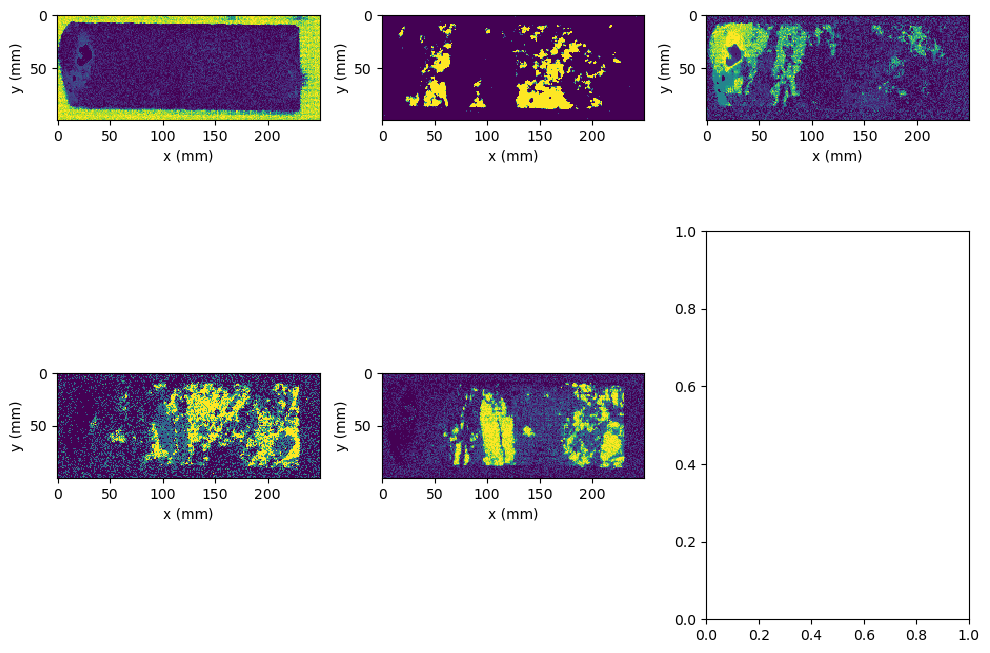

In [18]:
from skimage.filters import threshold_otsu
import cv2
thresholds=np.array([threshold_otsu(new_maps_cut[i]) for i in range(new_maps_cut.shape[0])])

maps_thres=[]
for i in range(new_maps_cut.shape[0]):
    c_mask=np.zeros(new_maps_cut.shape[1])
    for j in range(new_maps_cut.shape[1]):
        if new_maps_cut[i][j]>thresholds[i]:
            c_mask[j]=1
    maps_thres.append(c_mask)
maps_thres=np.array(maps_thres)  

kmeans = sklearn.cluster.KMeans(n_clusters = 5,random_state=0)
a=kmeans.fit_predict(maps_thres)
labels = kmeans.labels_
fig, ax = subplots(2, 3, figsize = (10, 8))
# clusters_c = np.array(kmeans.cluster_centers_.cpu())
clusters_c = np.array(kmeans.cluster_centers_)

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()


## Base

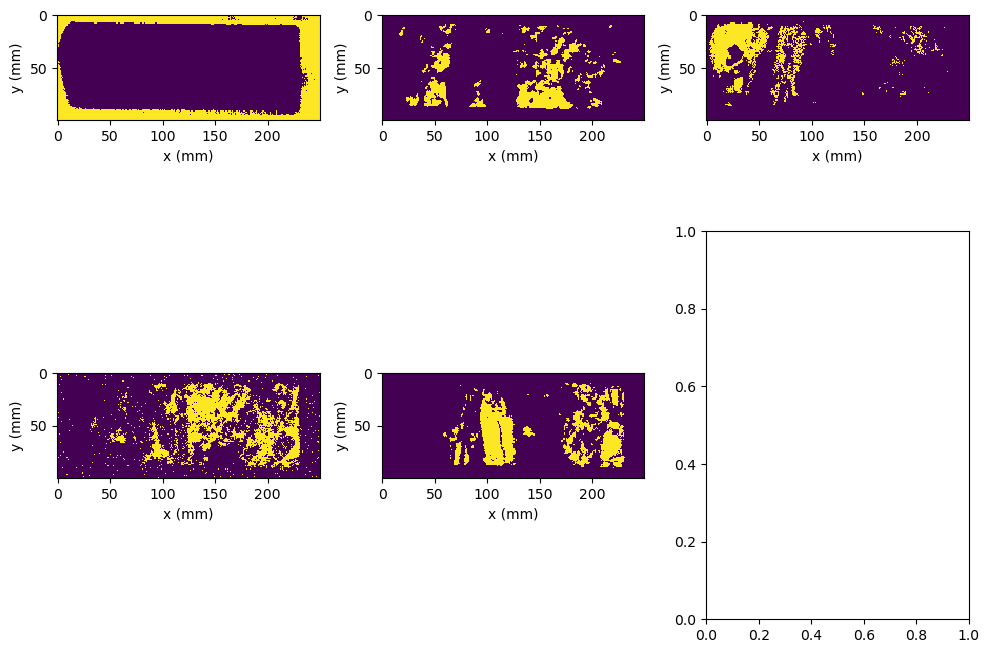

In [19]:
clusters_c = np.array(kmeans.cluster_centers_)
for i in range(clusters_c.shape[0]):
    for j in range(clusters_c.shape[1]):
        if clusters_c[i][j]<0.6:
            clusters_c[i][j]=0
        else:
            clusters_c[i][j]=1

fig, ax = subplots(2, 3, figsize = (10, 8))

j = 0
l = 0

for i in range(len(np.unique(labels))):
    axs = ax[l, j]
    # axs.imshow(clusters_c[i].reshape(pro_data.shape[:2]).T, interpolation = 'none')
    axs.imshow(clusters_c[i].reshape(pro_data.shape[0], pro_data.shape[1]).T, interpolation = 'none')
    axs.set_ylabel('y (mm)')
    axs.set_xlabel('x (mm)')
    axs.grid(False)
    j += 1
    if j == 3:
        j = 0
        l += 1

fig.tight_layout()


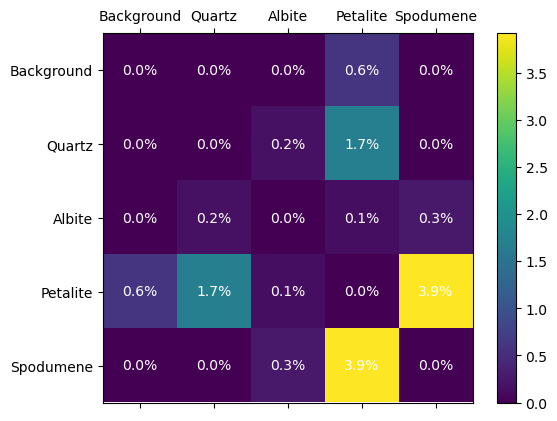

In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

num_images = np.array(clusters_c).shape[0]
minerals_order=['Background','Quartz','Albite','Petalite','Spodumene']

confusion_matrix = np.zeros((num_images, num_images))

for i in range(num_images):
    for j in range(i + 1, num_images):
        img_and = cv2.bitwise_and(clusters_c[i], clusters_c[j])
        
        overlap_value = np.sum(img_and) /(img_and.shape[0]*img_and.shape[1])*100

        confusion_matrix[i, j] = overlap_value
        confusion_matrix[j, i] = overlap_value

fig, ax = plt.subplots()
cax = ax.matshow(confusion_matrix)

ax.set_xticks(range(num_images))
ax.set_yticks(range(num_images))
ax.set_xticklabels(minerals_order)
ax.set_yticklabels(minerals_order)
for i in range(num_images):
    for j in range(num_images):
        plt.text(j, i, f'{confusion_matrix[i, j]:.1f}'+'%', ha='center', va='center', color='w')

fig.colorbar(cax)
plt.show()

Área de cobertura 78.0 %


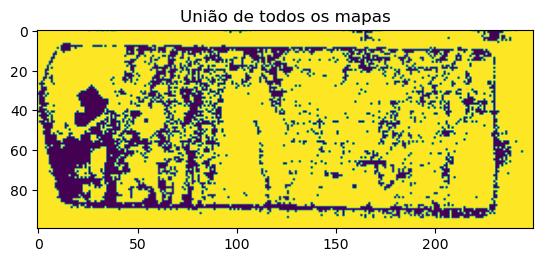

In [53]:
img_or = clusters_c[0]

for img in clusters_c[1:]:
    img_or = cv2.bitwise_or(img_or, img)
    
imshow(img_or.reshape(250,100).T)
plt.title('União de todos os mapas')
cut_int=img_or.copy()
print('Área de cobertura',round(sum(cut_int)/(cut_int.shape[0]*cut_int.shape[1]),2)*100, '%')

C:\Users\Joana\AppData\Local\Temp\ipykernel_2136\785083844.py:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  centre_circle = plt.Circle((0, 0), color='white', edgecolor='black', linewidth=0.9)


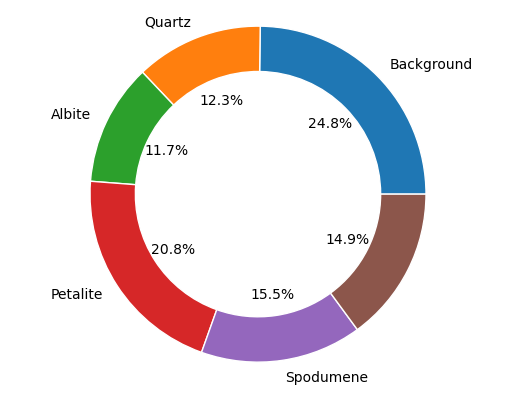

In [55]:
fig_ar=pro_data.shape[0]*pro_data.shape[1]
areas=[]
minerals_order=['Background','Quartz','Albite','Petalite','Spodumene']
for i in range (len(clusters_c)):
    a=np.sum(clusters_c[i])
    areas.append(a)
if fig_ar>np.sum(areas):
    areas.append((fig_ar-np.sum(areas)))
    minerals_order.append(' ')
fig, ax = plt.subplots()


centre_circle = plt.Circle((0, 0), color='white', edgecolor='black', linewidth=0.9)
ax.add_artist(centre_circle)

ax.pie(areas, labels=minerals_order, autopct='%1.1f%%', wedgeprops=dict(width=0.27, edgecolor='w'))
ax.axis('equal')  
plt.show()


## Classificação por overlap

In [24]:
## thresholding de todos os mapas
thresholds=np.array([threshold_otsu(entropy_masks[i]) for i in range(entropy_masks.shape[0])])

maps_thres=[]
for i in range(entropy_masks.shape[0]):
    c_mask=np.zeros(entropy_masks.shape[1])
    for j in range(entropy_masks.shape[1]):
        if entropy_masks[i][j]>thresholds[i]:
            c_mask[j]=1
    maps_thres.append(c_mask)
maps_thres=np.array(maps_thres)  

In [25]:
maps_thres.shape

(297, 25000)

In [26]:
def intersection_maps(maps):
    img_and = maps[0]

    for img in maps[1:]:
        img_and = cv2.bitwise_and(img_and, img)
    return img_and
int_all=[]
for i in range(clusters_c.shape[0]):
    int_s=[]
    for j in range(maps_thres.shape[0]):
        int_s.append(sum(intersection_maps([clusters_c[i],maps_thres[j]]))/sum(clusters_c[i]))
    int_all.append(int_s)
    
int_all=np.array(int_all)
int_all.shape

(5, 297)

In [49]:
contain=np.zeros([int_all.shape[0],int_all.shape[1]])
for i in range(int_all.shape[0]):
    for j in range(int_all.shape[1]):
        if int_all[i][j]>0.85:
            contain[i][j]=1

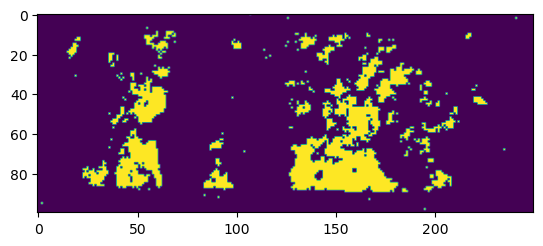

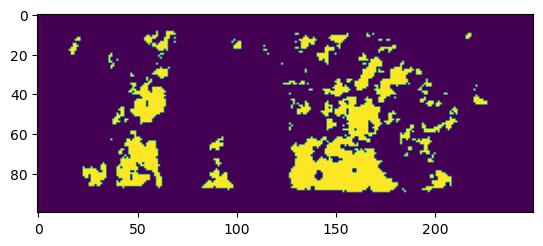

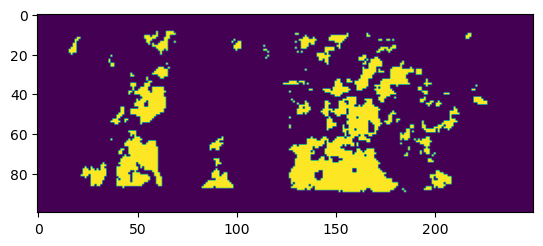

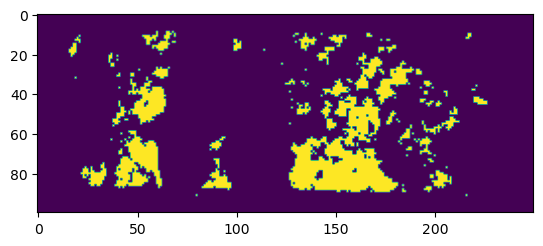

In [50]:
for i in range(contain.shape[1]):
    if contain[1][i]==1:
        imshow(maps_thres[i].reshape(250,100).T)
        plt.show()

Raman bands
[376.6393602499393, 380.94017751912907, 385.23858143269536, 389.5345703979219, 725.2668313108752, 729.362840598731, 733.4563377696013, 737.5473220145541, 1296.4214550707184, 1300.1459373155903, 1374.0995342250571, 1377.7704283827716, 1381.4387733255044, 1385.104569327439]
Raman bands
[457.9407019202208, 462.1954032270896, 466.4476626994219, 470.6974789407468]
Raman bands
[474.9448505646287, 479.18977619464385, 483.43225446435645, 504.60788827831675, 508.8356542465317, 513.060963566546]
Raman bands
[363.72244439525457, 491.909863506864]
Raman bands
[350.7838667005981, 355.09913005971976, 359.4119898435638, 700.6380674831562, 704.7491320157078, 708.8576894611997, 712.9637389601976, 1072.1537104451563]


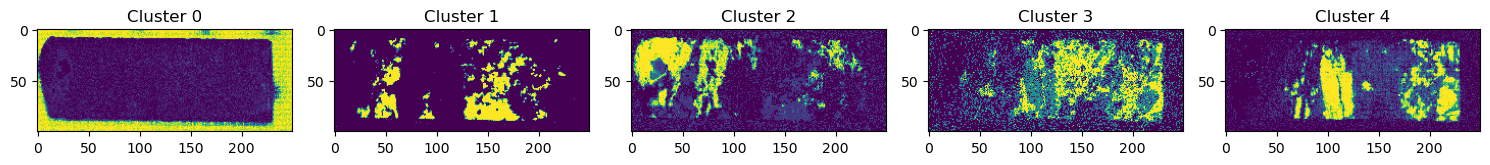

In [51]:
import matplotlib.pyplot as plt

# Assuming you have a total of 5 types of clusters
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # 1 row, 5 columns for subplots
clusters_o=[]
for cluster_type, ax in enumerate(axes):
    maps = []
    weights = []
    bands=[]
    for i in range(contain.shape[1]):
        if contain[cluster_type][i] == 1:
            maps.append(maps_thres[i])
            weights.append(int_all[cluster_type][i])
            bands.append(wavelengths[i])
    norm_weights = np.array(weights) / np.sum(weights)

    cluster = np.zeros(new_maps_cut[0].shape)
    for i in range(norm_weights.shape[0]):
        cluster += norm_weights[i] * maps[i]
    
    # Display the cluster in the corresponding subplot
    ax.imshow(cluster.reshape(250, 100).T)
    ax.set_title(f'Cluster {cluster_type}')
    clusters_o.append(cluster)
    print('Raman bands')
    print(bands)
    
plt.tight_layout()
plt.show()
